In [29]:
# This notebook discusses how we implement ACQUISITION FUNCTION using botorch

!pip install gpytorch &> /dev/null
!pip install botorch &> /dev/null

In [30]:
import torch
import math
import gpytorch
import botorch
import matplotlib.pyplot as plt
import numpy as np
from botorch.fit import fit_gpytorch_model
import matplotlib
from matplotlib import cm # for visualations
from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel, LinearKernel, PeriodicKernel
from botorch.acquisition import PosteriorMean, UpperConfidenceBound, ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.sampling import SobolQMCNormalSampler
from gpytorch.constraints.constraints import Interval
from gpytorch.likelihoods.gaussian_likelihood import GaussianLikelihood
from gpytorch.constraints import GreaterThan
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from botorch.optim import optimize_acqf
plt.rcParams.update({'font.size':16})

import warnings
warnings.filterwarnings('ignore')

In [31]:
# STANDARD ACQUISITION FUNCTION

def get_trained_GP(X, Y, kernel_type, noise_free=False,plot_1d=False, plot_bounds=None):
    if X.ndim < 2:
        raise ValueError("X should be 2D (shape: n x d)")
    if Y.ndim == 1:
        Y = Y.unsqueeze(-1)
    
    # outcome transform: standardize outputs during training and inverse-transform on predict
    standardize = Standardize(m=Y.shape[-1])
    output_transform = standardize

    input_dim = X.shape[-1]
    if kernel_type == "RBF":
        covar_module = ScaleKernel(RBFKernel(ard_num_dims=input_dim))
    elif kernel_type == "Linear":
        covar_module = ScaleKernel(LinearKernel(ard_num_dims=input_dim))
    elif kernel_type == "Periodic":
        covar_module = ScaleKernel(PeriodicKernel(ard_num_dims=input_dim))
    elif kernel_type == "Matern05":
        covar_module = ScaleKernel(MaternKernel(nu=0.5, ard_num_dims=input_dim))
    elif kernel_type == "Matern15":
        covar_module = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=input_dim))
    elif kernel_type == "Matern25":
        covar_module = ScaleKernel(MaternKernel(nu=2.5, ard_num_dims=input_dim))
    else:
        raise ValueError("Unsupported kernel_type: {}".format(kernel_type))
    
    # configure likelihood (allow small noise for noise-free data)
    if noise_free:
        likelihood = GaussianLikelihood(noise_constraint=Interval(lower_bound=1e-5,upper_bound=1e-3))
    else:
        likelihood = GaussianLikelihood(noise_constraint=Interval(lower_bound=1e-5,upper_bound=100))

    # build GP using the provided training data (use X and Y, not x/y)
    model = SingleTaskGP(train_X = X,
                         train_Y = Y,
                         covar_module=covar_module,
                         likelihood=likelihood,
                         outcome_transform=output_transform
                         )
    mll = ExactMarginalLogLikelihood(model.likelihood,model)
    fit_gpytorch_model(mll)

    model.eval()
    
    # optional 1D plotting (ensure shapes are correct)
    if plot_1d:
        if input_dim == 1:
            if plot_bounds is None:
                print("Please provide plot_bounds for 1D plotting")
            else:
                # make sure x_list has shape (n, d)
                x_list = torch.linspace(plot_bounds[0], plot_bounds[1], 200).unsqueeze(-1)
                posterior = model.posterior(x_list)
                mean = posterior.mean.squeeze(-1)
                var = posterior.variance.squeeze(-1)
                lcb = mean - 2 * torch.sqrt(var)
                ucb = mean + 2 * torch.sqrt(var)
                plt.figure(figsize=(8,6))
                plt.plot(x_list.squeeze(-1).detach().numpy(), mean.detach().numpy(), 'b', label='Mean')
                plt.fill_between(x_list.squeeze(-1).detach().numpy(), lcb.detach().numpy(), ucb.detach().numpy(), alpha=0.5, label='Uncertainty')
                plt.scatter(X.detach().numpy(), Y.detach().numpy(), c='r', marker = "*")
                plt.xlabel("X")
                plt.ylabel("Y")
                plt.legend()
        else:
            print("Input dimension is not 1, cannot plot")
    return model

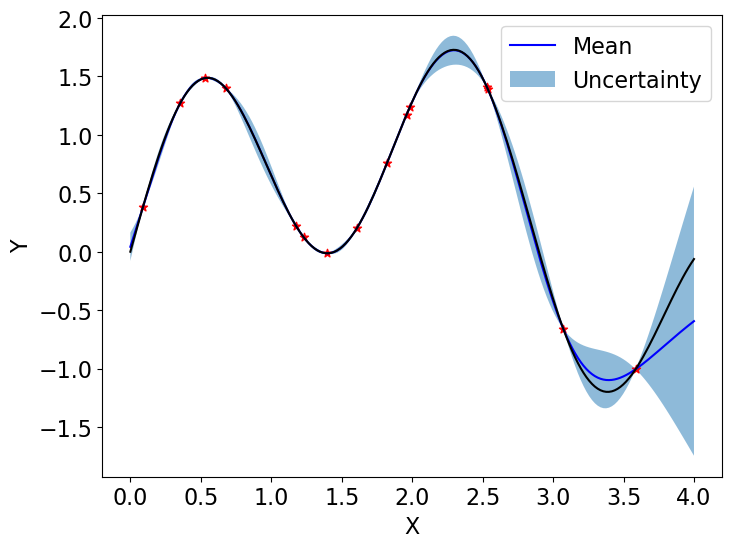

In [32]:
f = lambda x: torch.sin(x)+torch.sin((10.0/3.0)*x)

x_min, x_max = 0.0, 4.0

Ninit = 15
torch.manual_seed(0)
x_train = (x_max - x_min) * torch.rand(Ninit, 1) + x_min
y_train = f(x_train)

model = get_trained_GP(x_train, y_train, kernel_type="Matern25", noise_free=False, plot_1d=True, plot_bounds=(x_min, x_max))
x_list = torch.linspace(x_min, x_max, 200)
plt.plot(x_list, f(x_list),"-k");

In [35]:
import torch
from botorch.models import SingleTaskGP
from botorch.acquisition import ExpectedImprovement
from botorch.models.transforms import Standardize,Normalize
from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel, LinearKernel, PeriodicKernel
from gpytorch.constraints.constraints import Interval
from gpytorch.likelihoods.gaussian_likelihood import GaussianLikelihood

In [83]:
# Expected Improvement (EI) Acquisition Function
# evaluates how much of an improvement we expect over the best observed value over the current posterior maximum 
x_min,x_max = 0.0,4.0
Ninit=15
# torch.manual_seed(0)
f = lambda x: torch.cos(3.0*x)+torch.sin(5.0*x)

X = (x_max-x_min)*torch.rand(Ninit,1)+x_min
Y = f(X)

model = get_trained_GP(X, Y, kernel_type="RBF", noise_free=False, plot_1d=False, plot_bounds=(x_min, x_max))
best_val = Y.max() # called the incumbent in some literature
ei = ExpectedImprovement(model=model, best_f=best_val, maximize=True)

x_test = torch.linspace(x_min, x_max, 1001).reshape((1001,1))
x_test = x_test.unsqueeze(1)
# botrch requires 3D input (q, n, d) where q is the number of candidates (1 here), n is the number of points (1001 here), and d is the input dimension (1 here)
# analytic EI only supports q=1 (evaluating one point at a time)

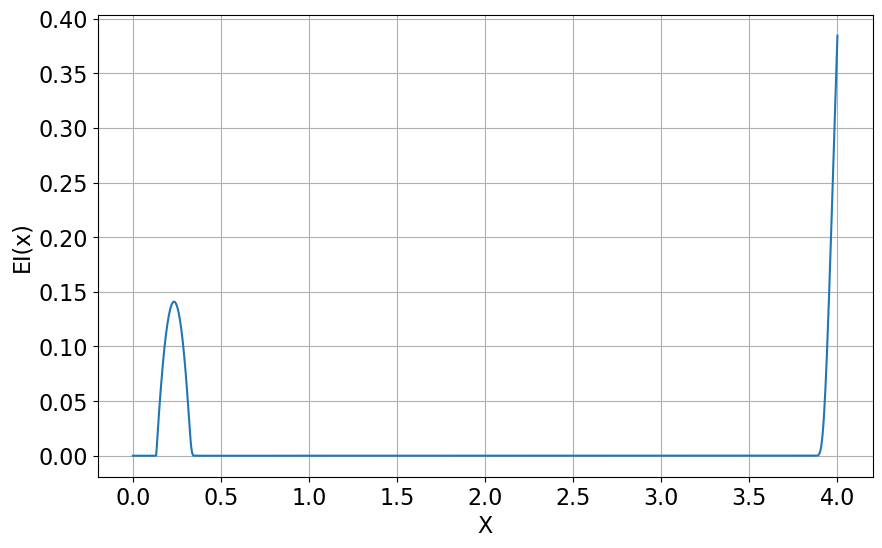

In [84]:
with torch.no_grad():
    EI_vals = ei(x_test)

plt.figure(figsize=(10,6))
plt.plot(x_test.squeeze(1), EI_vals)
plt.xlabel("X")
plt.ylabel("EI(x)")
plt.grid()

In [90]:
x = torch.tensor([0.0], requires_grad=True)
x_unsqueeze = x.unsqueeze(1)
ei_val = ei(x_unsqueeze)
ei_val.backward()
ei_grad = x.grad
print("EI at x=0: ", ei_val.item())
print("Gradient of EI at x=0: ", ei_grad.item())

EI at x=0:  1.260707649386461e-10
Gradient of EI at x=0:  -1.0061798505489605e-08


tensor([[4.]])
tensor(0.3843)


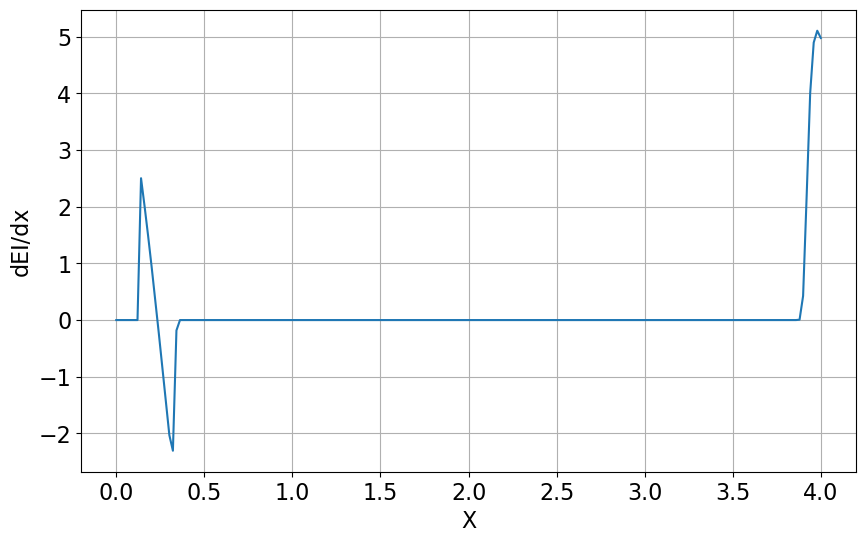

In [96]:
x_list = torch.linspace(x_min, x_max, 200).unsqueeze(-1)
ei_grad_list = torch.zeros_like(x_list)
for i in range(x_list.shape[0]):
    x = torch.tensor([x_list[i]], dtype=torch.float32, requires_grad=True)
    x_unsqueeze = x.unsqueeze(-1)
    ei_val = ei(x_unsqueeze)
    ei_val.backward() # computes gradient on ei(x) w.r.t x in order to find the next best point that maximizes EI; .backward() computes the gradient and stores it and upon calling x.grad() we can retrieve it
    ei_grad = x.grad # to call gradient of ei at x individually
    ei_grad_list[i] = ei_grad
plt.figure(figsize=(10,6))
plt.plot(x_list.squeeze(-1), ei_grad_list)
plt.xlabel("X") 
plt.ylabel("dEI/dx")
plt.grid()

print(x_test[torch.argmax(EI_vals)]) # x value that yields the maximum EI value
print(EI_vals.max()) # maximum EI value


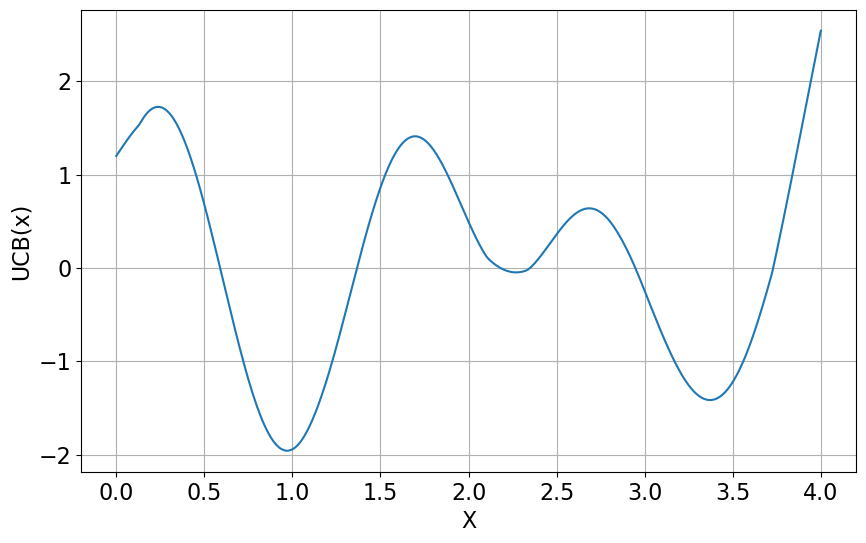

In [94]:
# UPPER CONFIDENCE BOUND (UCB) ACQUISITION FUNCTION
# evaluates how much of an improvement we expect over the best observed value over the current posterior maximum

ucb = UpperConfidenceBound(model=model, beta=4, maximize=True) # beta controls the trade-off between exploration and exploitation; higher beta means more exploration
# beta is usually set between 1 and 10; higher beta means more exploration
X = torch.linspace(x_min, x_max, 1001).reshape((1001,1))
X = X.unsqueeze(1)
# botorch requires 3D input (q, n, d) where q is the number of candidates (1 here), n is the number of points (1001 here), and d is the input dimension (1 here)

with torch.no_grad():
    UCB_vals = ucb(X)

plt.figure(figsize=(10,6))
plt.plot(X.squeeze(1), UCB_vals)
plt.xlabel("X")
plt.ylabel("UCB(x)")
plt.grid()

In [98]:
# Find the points that EI and UCB would recommend that you sample next. You can simply find these point that yields the largest EI and UCB values out of your grid of points
x_test_batch = x_test.unsqueeze(1)
ei_vals = ei(x_test_batch).squeeze(-1)
x_next_ei = x_test[torch.argmax(ei_vals)]
ucb_vals = ucb(x_test_batch).squeeze(-1)
x_next_ucb = x_test[torch.argmax(ucb_vals)]  
print("Next point to sample according to EI: ", x_next_ei.item())
print("Next point to sample according to UCB: ", x_next_ucb.item())

Next point to sample according to EI:  4.0
Next point to sample according to UCB:  4.0


In [102]:
# Maximizing the Acqusition Function

def optimize_my_acqf(acq, xL, xU, num_restarts=10, raw_samples=1000):

    """
    Args:
    acq: the specified acquisition function -- botorch class
    xL: Lower limit of X (input variables) -- torch tensor (1d)
    xU: Upper limit of Y (output variables) -- torch tensor (1d)
    num_restarts: Number of multi-starts to perform -- integer
    raw_samples: Number of random initial samples to use to generate multi-start candidates

    ----------
    returns:

    new_point : next point (x) to sample to obtain f(x) -- torch tensor    
    acq_val : the value of the acquisition function at this point -- torch tensor    
    """  
    
    # multi-start: induce multiple start points to avoid getting stuck in a local maxima
    # for each start, an optimizer ends up in a local maxima
    # After all maxima are computed the best one is chosen 

    # write out bounds in botorch notation
    nx = xL.shape[0] # number of input dimensions
    bounds = torch.tensor([[xL[i],xU[i]] for i in range(nx)]).T # generate 2D tensor of shape (2,nx) for botorch; one for lower bounds and one for upper bounds

    try:
        new_point, acq_value_list = optimize_acqf(acq_function=acq,
                                 bounds=bounds,
                                 q=1, # number of candidates to generate
                                 num_restarts=num_restarts, # number of multi-starts to perform
                                 raw_samples=raw_samples, # number of random samples to generate as starting points
                                 )
        acq_val = acq_value_list.numpy()
    except:
        print("Optimization of acquisition function failed. Returning None")
        new_point = None
        acq_val = None
    return new_point, acq_val

In [103]:
best_value = y_train.max()
ei = ExpectedImprovement(model=model, best_f=best_value, maximize=True)
ucb = UpperConfidenceBound(model=model, beta=4, maximize=True)

name_list = ["EI","UCB"]
acq_list = [ei, ucb]

for (i,acq) in enumerate(acq_list):
    x_next, acq_val = optimize_my_acqf(acq, torch.tensor([x_min]), torch.tensor([x_max]), num_restarts=20, raw_samples=2000)
    print("Next point to sample according to {}: {}".format(name_list[i], x_next))
    print("Acquisition function value at this point: {}".format(acq_val))

Next point to sample according to EI: tensor([[4.]])
Acquisition function value at this point: 0.5820352435112
Next point to sample according to UCB: tensor([[4.]])
Acquisition function value at this point: 2.5408995151519775
